In [1]:
from keras.models import Sequential, load_model
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
import fnmatch
import nibabel as nib 
import shutil
%matplotlib inline

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [26]:
def gather_images(data_path):
    images = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if '_M' in f:
        images.append(f)
        
      else:
        continue
        #segmentations.append(f.replace('.nii', '_K.nii'))

    #print(images[0], segmentations[0])
    images = np.array(images)
    #segmentations = np.array(segmentations)

    indices = np.array(range(len(images))) # we will use this in the next step.

    return images

In [13]:
model = custom_unet(input_shape=(512,512,2), num_classes=2)
#UNET_KU_EM_UB_train_MA_val
#UNET_MA_EM_UB_train_KU_val
#UNET_MA_KU_EM_train_UB_val
#UNET_MA_KU_UB_train_EM_val
#ALL_INSTITUTION_80-20
model.load_weights("kidney_mask_test.h5")
model_name = 'test'

In [27]:
data_path = r'C:\Users\UAB\data\Emory\data'
images = gather_images(data_path)

In [28]:
print(images[0])
print(len(images))
print(images[0:2])

EM_200922_0_144_L_0_M.npy
23488
['EM_200922_0_144_L_0_M.npy' 'EM_200922_0_144_L_100_M.npy']


In [29]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}


We need to gather a stack of 32 images for the prediction in the shape (32, 512, 512, 1)


In [30]:
#divide the number of images avaliable into batches of 32, then we can feed it a batch at a time and 
# then we can append to the larger stack



label_list = []
predictions = []
pred_path = r"C:\Users\UAB\data\Emory\CystPredictions"
images = gather_images(data_path)
#DELETE THIS
images = images[0:64]

batches = len(images)//32
left_over = len(images)%32 
print(batches, left_over)


#REMEMBER TO COME BACK FOR LEFTOVERS
for i in range(batches):
    image_stack = np.empty((32,512,512,2))
    for x in range(32*i, (32*(i+1))):
        image = np.load(data_path +"\\"+images[x])
        name = str(images[x][:-5] + 'K.npy')
        mask  = np.load(data_path +"\\"+ name)
        y = x-(32*i)
        #print(x, y)
        image_stack[y, ...,0] = image[...]
        image_stack[y, ...,1] = mask[...]
        label_match = str(images[x][:-5] + 'C.npy')
        #print(label_match)
        label_list.append(label_match)
        
    img_prediction = model.predict(image_stack)
    img_prediction = img_prediction.astype('float')
    #print(img_prediction.shape)
    for z in range(len(img_prediction)):
        #print('saving images')
        img_numb = z + 32*i
        #print(z, img_numb)
        image_save = img_prediction[z,:,:]
        label = label_list[img_numb][:-5]
        filename = str(label + model_name + '_P.npy')
        np.save(os.path.join(pred_path, filename), image_save)  


2 0


Get left over images predicted on

In [67]:
left_images = images[-left_over:]
print(len(left_images))
print(left_images[0])

16
UB_407132_3_10_L_3_M.npy


In [68]:
image_stack = np.empty((32,512,512,1))
label_left = []
for i in range(len(left_images)):
    image = np.load(data_path +"\\"+left_images[i])
    image_stack[i, ...,0] = image[...]
    label_match = str(left_images[i][:-5] + 'K.npy')
    label_left.append(label_match)
img_prediction = model.predict(image_stack)
img_prediction = img_prediction.astype('float')

for z in range(len(left_images)):
        #print('saving images')
        #print(z, img_numb)
        image_save = img_prediction[z,:,:]
        label = label_left[z][:-5]
        filename = str(label + model_name + '_P.npy')
        np.save(os.path.join(pred_path, filename), image_save)  

## Everything below here is to look at predictions, and needs to be cleaned up
im just too afraid to delete it


In [45]:
prediction = np.load(r"C:\Users\UAB\data\Emory\CystPredictions\EM_200922_0_144_L_100_test_P.npy")
image = np.load(r"C:\Users\UAB\data\Emory\data\EM_200922_0_144_L_100_M.npy")
kidney = np.load(r"C:\Users\UAB\data\Emory\data\EM_200922_0_144_L_100_K.npy")
true = np.load(r"C:\Users\UAB\data\Emory\data\EM_200922_0_144_L_100_C.npy")

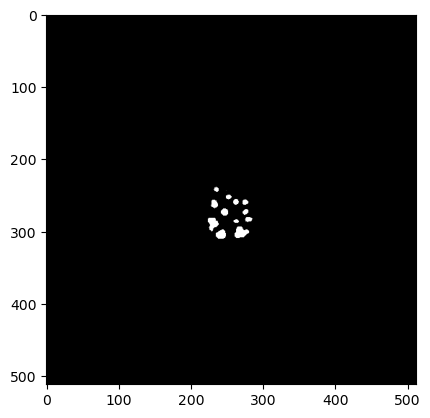

In [49]:
plt.imshow(prediction[:,:,1], cmap='gray')

<Figure size 640x480 with 0 Axes>

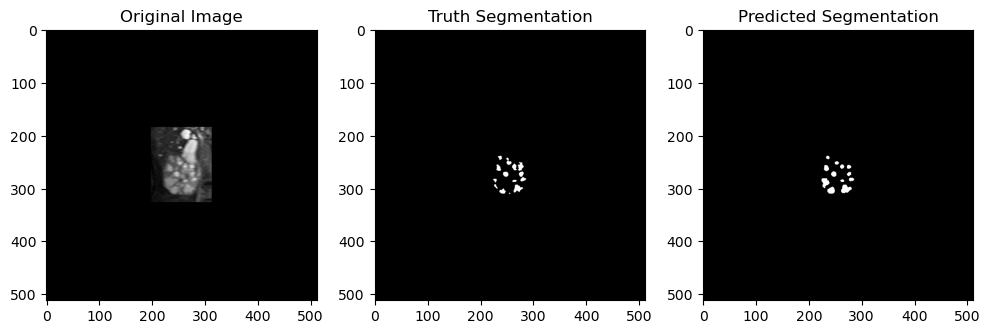

In [50]:
plt.figure()
f, axarr = plt.subplots(nrows = 1, ncols = 3, figsize=(10,10))
f.tight_layout()

axarr[0].imshow(image, cmap="gray")
axarr[0].title.set_text('Original Image')
axarr[1].imshow(true, cmap='gray')
axarr[1].title.set_text('Truth Segmentation')
axarr[2].imshow(prediction[:,:,1], cmap='gray')
axarr[2].title.set_text('Predicted Segmentation')

In [52]:
img_path = r"C:\Users\UAB\data\Emory\CystPredictions"
name = 'first cyst prediction.png'

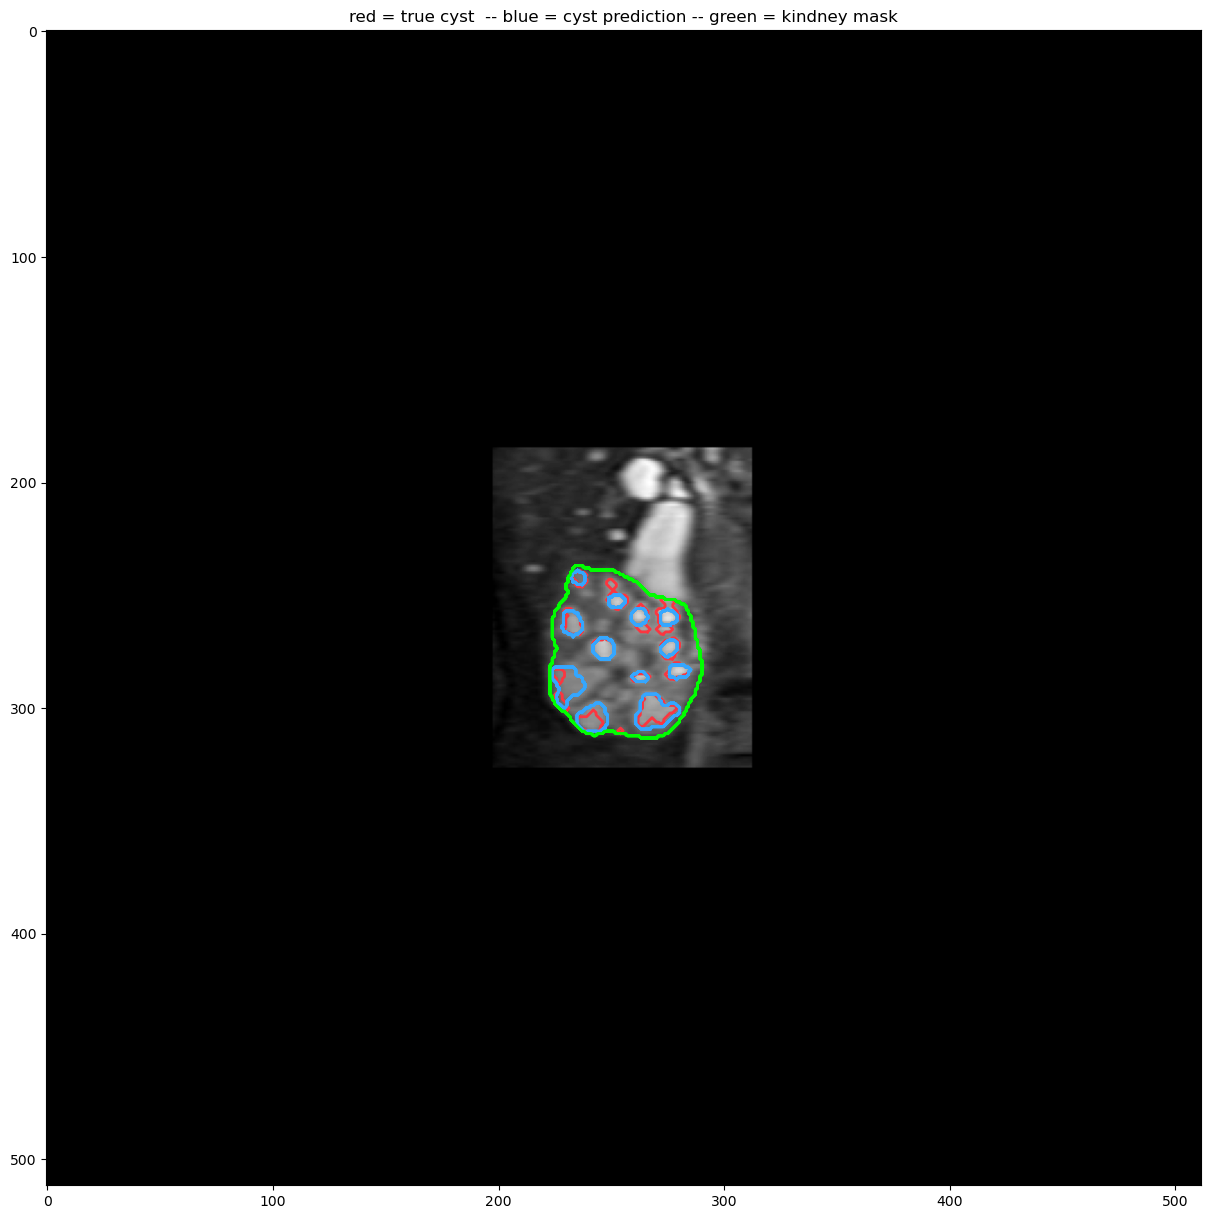

In [53]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot()
ax.imshow(image, cmap=plt.cm.gray)

contours = measure.find_contours(true, 0.8)
for j,contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0],color='#FB3640', lw=2)
    contours = measure.find_contours(prediction[:,:,1], 0.8)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0],color='#35A7FF', lw=2)
        contours = measure.find_contours(kidney, 0.8)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0],color='#00FF00', lw=2)
        #contours = measure.find_contours(model_4[:,:,slice_num], 0.8)  
   # for contour in contours:
       # ax.plot(contour[:, 1], contour[:, 0],color='#FFFF00', lw=2)
       # contours = measure.find_contours(original[:,:,slice_num], 0.8)

ax.axis('image')
ax.title.set_text('red = true cyst  -- blue = cyst prediction -- green = kindney mask')
fig.savefig(os.path.join(img_path,name))